In [42]:
import simexpal
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [43]:
cfg = simexpal.config_for_dir("./")

In [44]:
TITLE_SIZE = 16
TICK_SIZE = 15
LABEL_SIZE = 16

plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)

## Sequential

In [45]:
def parse_seq(run):
    
    # Get all used parameter
    var_dict = dict()
    for var in run.experiment.variation:
        var_dict[var.axis] = var.name
    #print(var_dict)

    output_dict = dict()
    # Read output
    oFile = run.open_output_file()
    affected_nodes_values = [0] * 50
    dyn_runtime_values = [0.0] * 50
    speedup_values = [0.0] * 50
    static_runtime = 0.0
    
    for line in oFile:
        if line.startswith("(Dynamic) affected nodes per run:"):
            for i in range(50):
                next_line = next(oFile).strip()
                if next_line:
                    value = int(next_line)
                    affected_nodes_values[i] = value
            #avg_affected_nodes = affected_nodes_values / 50
        elif line.startswith("(Dynamic) runtimes [s] per run:"):
            for i in range(50):
                next_line = next(oFile).strip()
                if next_line:
                    value = float(next_line)
                    dyn_runtime_values[i] = value
            #avg_runtime = dyn_runtime_values / 50.0
        elif line.startswith("(Static) runtimes [s] per run:"):
            next_line = next(oFile).strip()
            static_runtime = float(next_line)

    for idx, val in enumerate(dyn_runtime_values):
        speedup_values[idx] = static_runtime / val
    
    return {
        'experiment': run.experiment.name,
        'instance': run.instance.shortname,
        'group': list(run.instance.instsets)[0],
        'b': var_dict['b_value'].split('3_b_val=')[1],
        'operation': var_dict['operation'].split('1_op=')[1],
        'batch_size': var_dict['batch_size'].split('2_batch_s=')[1],
        'affected_nodes': affected_nodes_values,
        'dyn_runtime': dyn_runtime_values,
        'speedup': speedup_values,
        'static_runtime': static_runtime
    }

In [46]:
results_seq = []
for successful_run in cfg.collect_successful_results():
    if 'dynamic' in successful_run.experiment.name:
        results_seq.append(parse_seq(successful_run))

In [47]:
df_seq = pd.DataFrame(results_seq)
df_seq = df_seq.sort_values(by=['group'])

groupSeries = np.sort(pd.unique(df_seq.group)).astype(str)
df_seq['group'] = pd.Categorical(df_seq['group'], categories=groupSeries, ordered=True)

df_seq

,experiment,instance,group,b,operation,batch_size,affected_nodes,dyn_runtime,speedup,static_runtime
638,dynamic-b-suitor,rmat-g,random,10,remove,10e2,"[48, 41, 34, 30, 41, 55, 30, 50, 25, 40, 25, 3...","[0.000153162, 0.000135285, 0.000114707, 0.0001...","[37869.3148431073, 42873.489300365894, 50564.8...",5.800140
217,dynamic-b-suitor,rmat-er,random,1,insert,10e2,"[20, 29, 32, 22, 15, 29, 11, 13, 40, 30, 33, 2...","[4.6103e-05, 4.4246e-05, 4.0539e-05, 3.2469e-0...","[27245.29857059193, 28388.78090674863, 30984.7...",1.256090
218,dynamic-b-suitor,rmat-g,random,1,insert,10e2,"[49, 29, 32, 34, 24, 32, 18, 28, 26, 12, 39, 2...","[6.5048e-05, 3.1615e-05, 2.9546e-05, 4.0592e-0...","[17146.41495511007, 35278.82334334967, 37749.2...",1.115340
651,dynamic-b-suitor,hyp-24-1,random,2,remove,10e2,"[70, 63, 54, 58, 67, 72, 67, 71, 57, 74, 48, 6...","[0.00011618, 9.8452e-05, 8.0903e-05, 8.7383e-0...","[97158.71922878292, 114653.84146589201, 139523...",11.287900
231,dynamic-b-suitor,hyp-24-1,random,10,insert,10e2,"[133, 136, 120, 114, 113, 125, 125, 107, 123, ...","[0.000159026, 0.000158788, 0.000135698, 0.0001...","[353366.1162325658, 353895.76038491575, 414113...",56.194400
...,...,...,...,...,...,...,...,...,...,...
210,dynamic-b-suitor,human_gene2,real_sparse,1,insert,10e2,"[0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 4, 2, 0, 2, 0, ...","[8.347e-06, 6.839e-06, 7.065e-06, 7.222e-06, 7...","[27188.211333413205, 33183.21392016377, 32121....",0.226940
532,dynamic-b-suitor,mouse_gene,real_sparse,10,remove,10e1,"[8, 6, 3, 6, 10, 7, 8, 5, 0, 8, 4, 9, 0, 2, 6,...","[7.7568e-05, 9.7257e-05, 3.4031e-05, 9.2128e-0...","[45339.57301980198, 36160.89330330979, 103344....",3.516900
405,dynamic-b-suitor,cage14,real_sparse,1,remove,10e0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0664e-05, 1.503e-06, 1.083e-06, 1.043e-06, ...","[50915.978994748686, 361256.1543579508, 501355...",0.542968
646,dynamic-b-suitor,cage15,real_sparse,2,remove,10e2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0872e-05, 9.464e-06, 9.92e-06, 9.55e-06, 9....","[381564.56953642383, 438331.57227387995, 41818...",4.148370


In [48]:
df_affected = df_seq.groupby(['group','b','operation','batch_size']).agg({'affected_nodes' : 'sum'})
df_affected.reset_index(inplace=True)
for i, row in df_affected.iterrows():
    local_b = [row['b']] * len(row['affected_nodes'])
    df_affected['b'][i] = local_b

In [49]:
df_speedup = df_seq.groupby(['group','b','operation','batch_size']).agg({'speedup' : 'sum'})
df_speedup.reset_index(inplace=True)
for i, row in df_speedup.iterrows():
    local_b = [row['b']] * len(row['speedup'])
    df_speedup['b'][i] = local_b

In [135]:
# Plotting function
def plotter(localDf, column, op = None, rows = ['10e0','10e1','10e2','10e3'], single = False, log = False, order=[ '1', '3', '10', 'random'], use_box = False):
    y = 0
    found = False
    for idx, val in enumerate(rows):
        if (localDf['batch_size'] == val).all():
            y = idx
            found = True
            break
    if not found:
        return
    for i, val in enumerate(["real_sparse", "real_infrastructure", "real_social", "random"]):
        if op != None:
            localQuery = localDf.query('group == @val and operation == @op')
        else:
            localQuery = localDf.query('group == @val')
        if single:
            if use_box == False:
                sns.violinplot(x=localQuery['b'].sum(), y=localQuery[column].sum(), palette="Dark2", bw_adjust=1.2, inner="box", fill=True, linewidth=1, cut=0, density_norm="count", ax=axs[i], order=order, log_scale=log)
            else:
                sns.boxplot(x=localQuery['b'].sum(), y=localQuery[column].sum(), palette="Dark2", linewidth=2, ax=axs[i], order=[ '1', '3', '10', 'random'], log_scale=log)
        else:
            if use_box == False:
                sns.violinplot(x=localQuery['b'].sum(), y=localQuery[column].sum(), palette="Dark2", bw_adjust=1.2, inner="box", fill=True, linewidth=1, cut=0, density_norm="count", ax=axs[y, i], order=order, log_scale=log)
            else:
                sns.boxplot(x=localQuery['b'].sum(), y=localQuery[column].sum(), palette="Dark2", linewidth=2, ax=axs[y, i], order=[ '1', '3', '10', 'random'], log_scale=log)

### Speedup Plot (Paper)

#### Edge Insertion

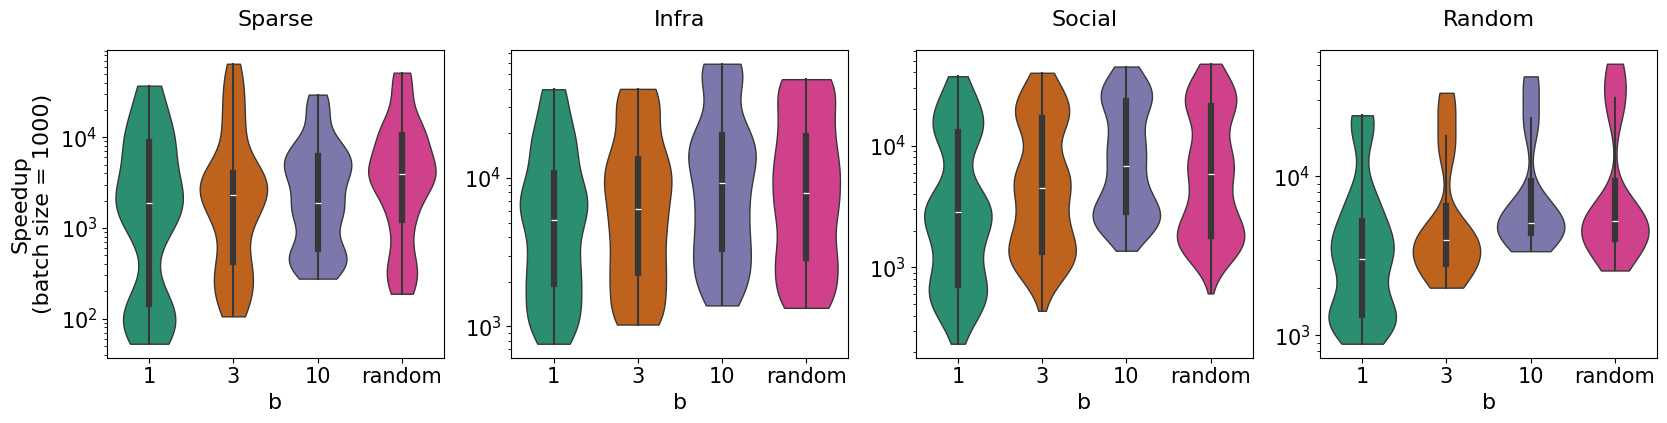

In [130]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharex='all')

cols = ['{}'.format(col) for col in ['Sparse', 'Infra', 'Social', 'Random']]
rows = ['{}'.format(col) for col in ['Speedup\n(batch size = 1)', 'Speedup\n(batch size = 10)', 'Speedup\n(batch size = 100)', 'Speedup\n(batch size = 1000)']]

for ax, col in zip(axs, cols):
    ax.set_title(col, y=1.05, fontsize=TITLE_SIZE)

axs[0].set_ylabel(rows[3], rotation=90, fontsize=LABEL_SIZE, labelpad=5)

for ax in axs[:]:
    ax.set_xlabel('b', fontsize=LABEL_SIZE)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
    
df_speedup.groupby('batch_size').apply(plotter, column = 'speedup', rows=['10e3'], single = True, log = True)
plt.savefig('./plots/speedup_paper.pdf', format="pdf", bbox_inches='tight')

### Affected nodes additional plots (extended version)

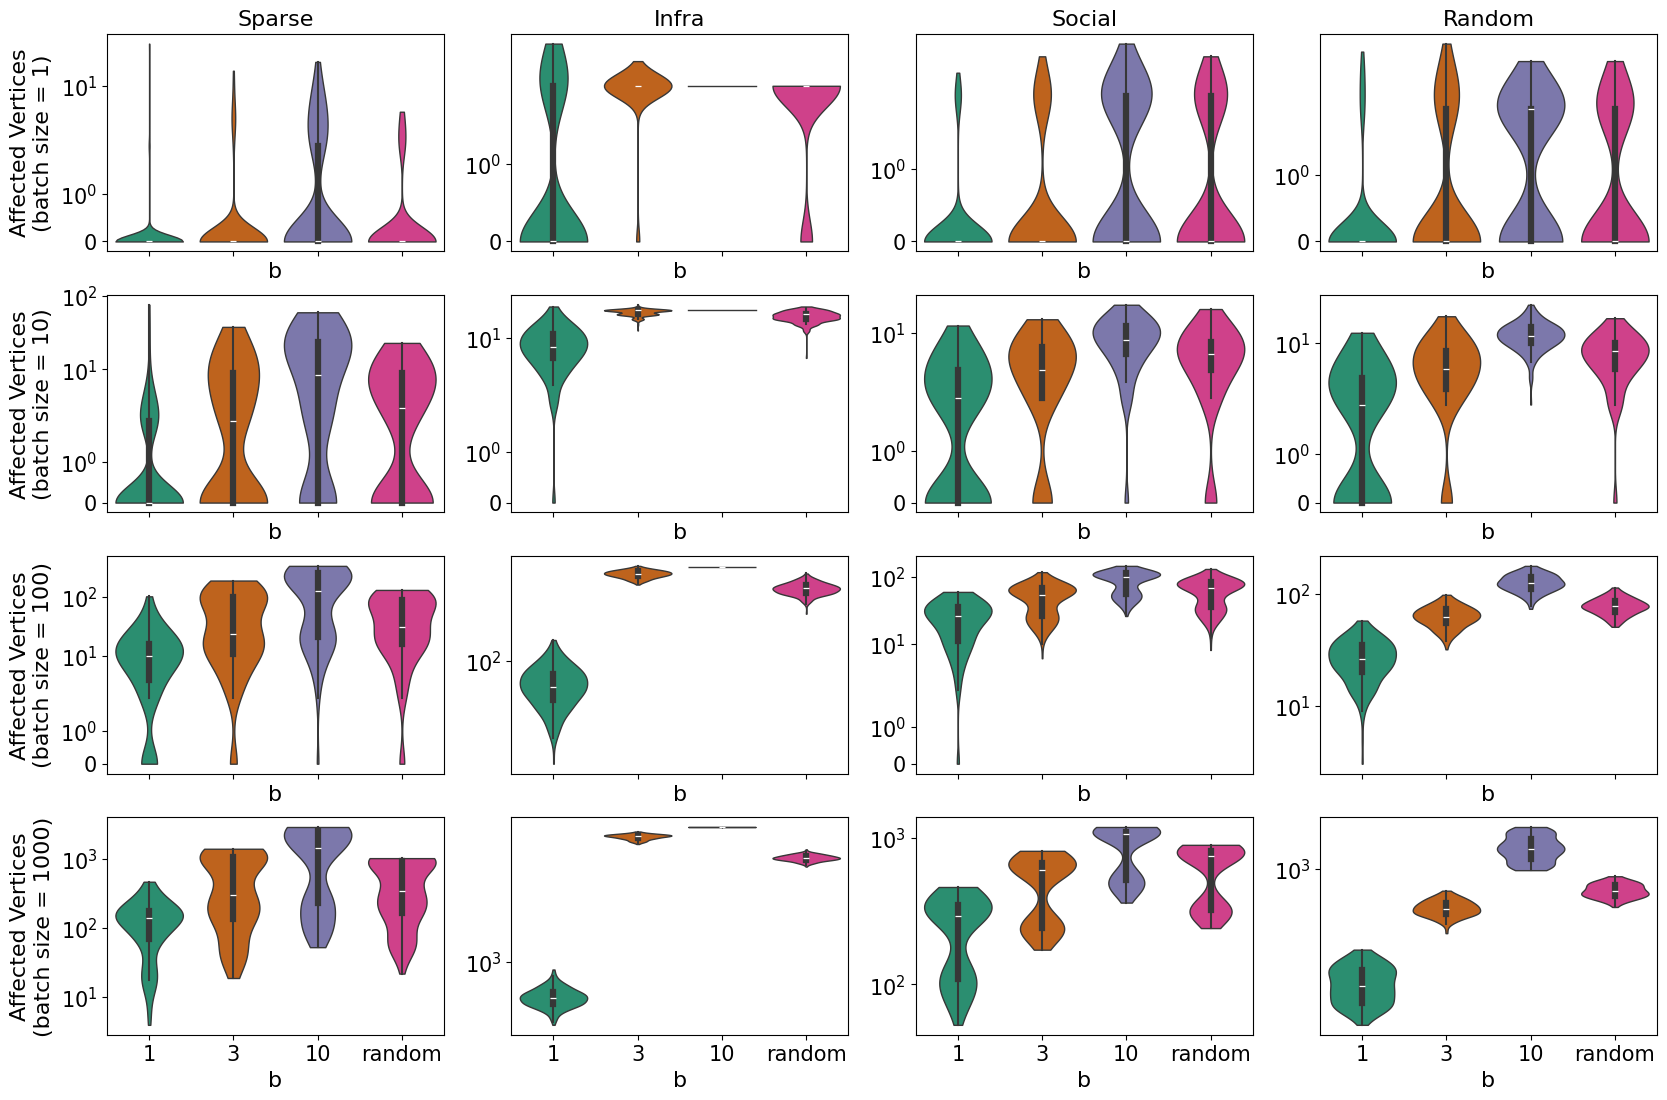

In [139]:
fig, axs = plt.subplots(4, 4, figsize=(20, 13), sharex='all')

cols = ['{}'.format(col) for col in ['Sparse', 'Infra', 'Social', 'Random']]
rows = ['{}'.format(col) for col in ['Affected Vertices\n(batch size = 1)', 'Affected Vertices\n(batch size = 10)', 'Affected Vertices\n(batch size = 100)', 'Affected Vertices\n(batch size = 1000)']]

for ax, col in zip(axs[0], cols):
    ax.set_title(col, fontsize=TITLE_SIZE)

axs[0,0].set_ylabel(rows[0], rotation=90, fontsize=LABEL_SIZE, labelpad=5)
axs[1,0].set_ylabel(rows[1], rotation=90, fontsize=LABEL_SIZE, labelpad=5)
axs[2,0].set_ylabel(rows[2], rotation=90, fontsize=LABEL_SIZE, labelpad=5)
axs[3,0].set_ylabel(rows[3], rotation=90, fontsize=LABEL_SIZE, labelpad=5)

for i in range(4):
    for ax in axs[i,:]:
        ax.set_xlabel('b', fontsize=LABEL_SIZE)
        ax.set_yscale('symlog')
    
#fig.suptitle("Edge Insertion", y=0.92, fontsize=15)
    
df_affected.groupby('batch_size').apply(plotter, op = 'insert', column = 'affected_nodes', use_box=False)
plt.savefig('./plots/affected_insertion_misc.pdf', format="pdf", bbox_inches='tight')

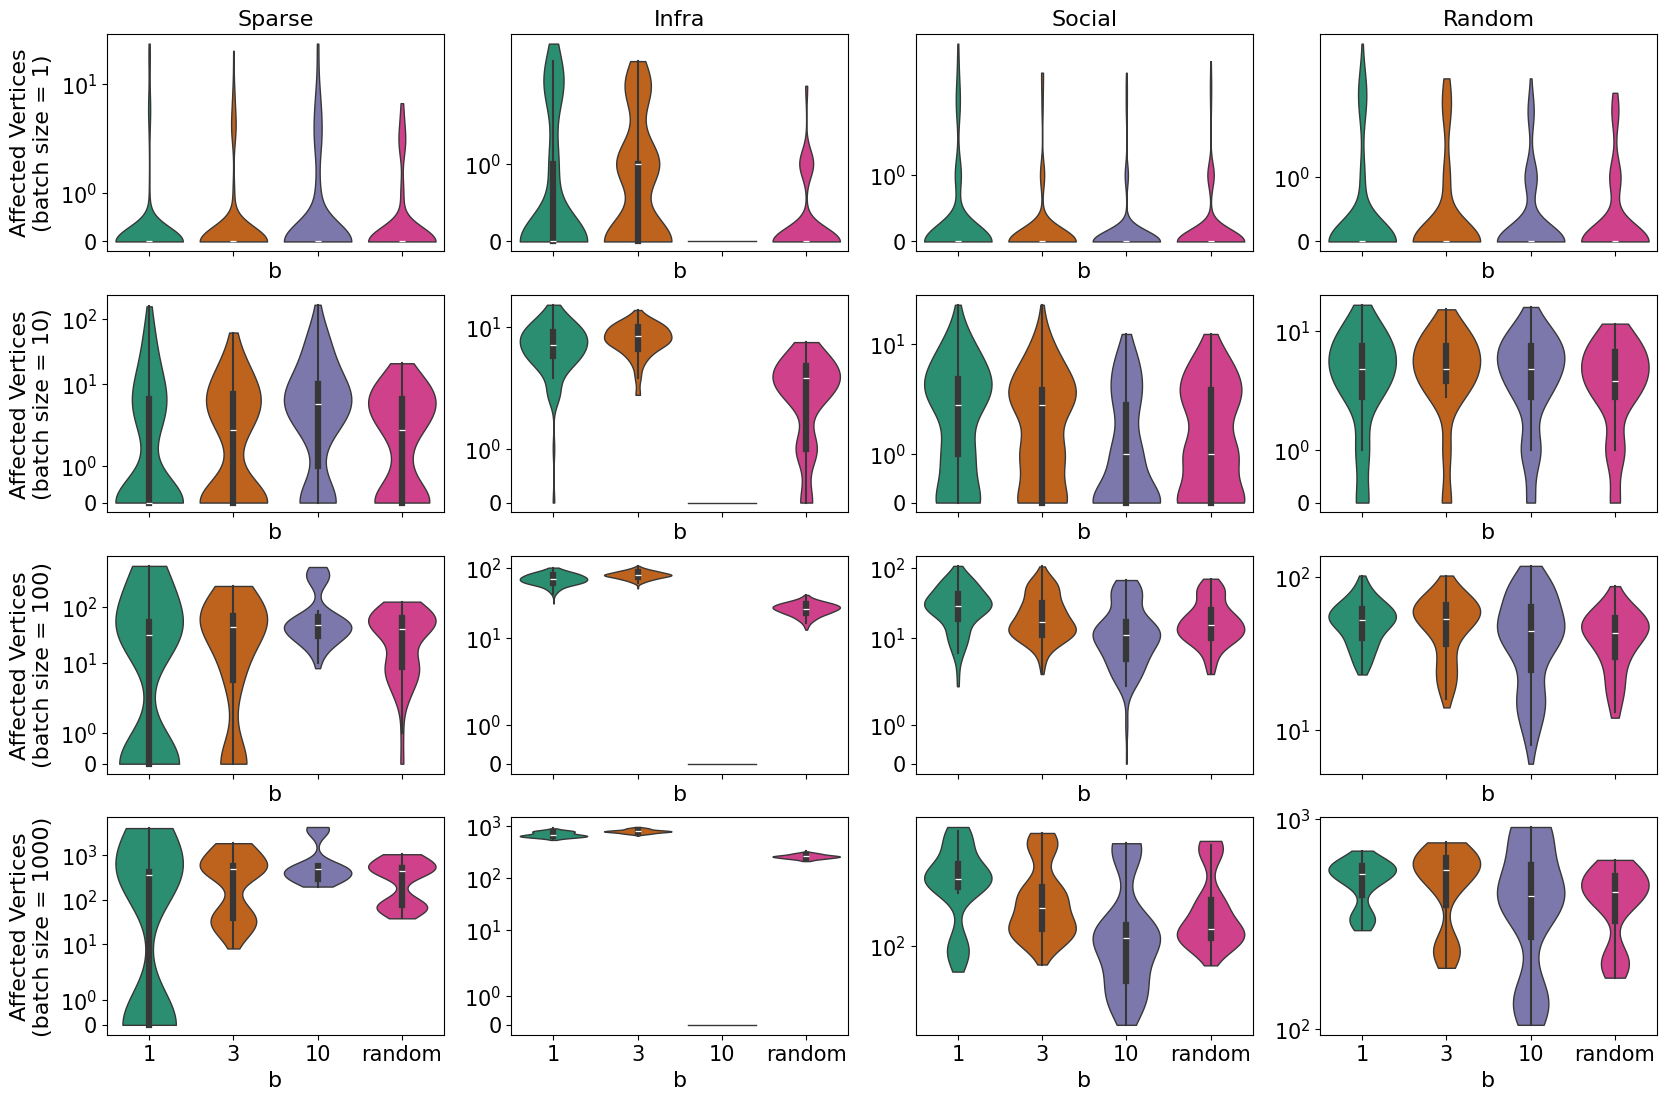

In [140]:
fig, axs = plt.subplots(4, 4, figsize=(20, 13), sharex='all')

cols = ['{}'.format(col) for col in ['Sparse', 'Infra', 'Social', 'Random']]
rows = ['{}'.format(col) for col in ['Affected Vertices\n(batch size = 1)', 'Affected Vertices\n(batch size = 10)', 'Affected Vertices\n(batch size = 100)', 'Affected Vertices\n(batch size = 1000)']]

for ax, col in zip(axs[0], cols):
    ax.set_title(col, fontsize=TITLE_SIZE)

axs[0,0].set_ylabel(rows[0], rotation=90, fontsize=LABEL_SIZE, labelpad=5)
axs[1,0].set_ylabel(rows[1], rotation=90, fontsize=LABEL_SIZE, labelpad=5)
axs[2,0].set_ylabel(rows[2], rotation=90, fontsize=LABEL_SIZE, labelpad=5)
axs[3,0].set_ylabel(rows[3], rotation=90, fontsize=LABEL_SIZE, labelpad=5)

for i in range(4):
    for ax in axs[i,:]:
        ax.set_xlabel('b', fontsize=LABEL_SIZE)
        ax.set_yscale('symlog')
    
#fig.suptitle("Edge Insertion", y=0.92, fontsize=15)
    
df_affected.groupby('batch_size').apply(plotter, op = 'remove', column = 'affected_nodes')
plt.savefig('./plots/affected_removal_misc.pdf', format="pdf", bbox_inches='tight')

### Average affected nodes

In [16]:

avg_affected_single_combined = df_affected.query('batch_size == "10e0"')['affected_nodes'].sum()
avg_affected_single_insertion = df_affected.query('batch_size == "10e0" and operation == "insert"')['affected_nodes'].sum()
avg_affected_single_removal = df_affected.query('batch_size == "10e0" and operation == "remove"')['affected_nodes'].sum()
avg_affected_single_insertion_sparse = df_affected.query('batch_size == "10e0" and operation == "insert" and group == "real_sparse"')['affected_nodes'].sum()
avg_affected_single_insertion_infra = df_affected.query('batch_size == "10e0" and operation == "insert" and group == "real_infrastructure"')['affected_nodes'].sum()
avg_affected_single_insertion_social = df_affected.query('batch_size == "10e0" and operation == "insert" and group == "real_social"')['affected_nodes'].sum()
avg_affected_single_insertion_random = df_affected.query('batch_size == "10e0" and operation == "insert" and group == "random"')['affected_nodes'].sum()
mask = df_affected.b.apply(lambda x: '1' in x)
avg_affected_single_ordinary = df_affected[mask].query('batch_size == "10e0"')['affected_nodes'].sum()

print("Single update (combined): ",np.format_float_scientific(np.mean(avg_affected_single_combined)))
print("Single update (insertion): ",np.format_float_scientific(np.mean(avg_affected_single_insertion)))
print("Single update (insertion, sparse): ",np.format_float_scientific(np.mean(avg_affected_single_insertion_sparse)))
print("Single update (insertion, infrastructure): ",np.format_float_scientific(np.mean(avg_affected_single_insertion_infra)))
print("Single update (insertion, social): ",np.format_float_scientific(np.mean(avg_affected_single_insertion_social)))
print("Single update (insertion, random): ",np.format_float_scientific(np.mean(avg_affected_single_insertion_random)))
print("Single update max (insertion, sparse): ",np.format_float_scientific(np.max(avg_affected_single_insertion_sparse)))
print("Single update max (insertion, infrastructure): ",np.format_float_scientific(np.max(avg_affected_single_insertion_infra)))
print("Single update max (insertion, social): ",np.format_float_scientific(np.max(avg_affected_single_insertion_social)))
print("Single update max (insertion, random): ",np.format_float_scientific(np.max(avg_affected_single_insertion_random)))
print("Single update (ordinary): ",np.format_float_scientific(np.mean(avg_affected_single_ordinary)))

avg_affected_batch_combined = df_affected.query('batch_size == "10e3"')['affected_nodes'].sum()
avg_affected_batch_insertion = df_affected.query('batch_size == "10e3" and operation == "insert"')['affected_nodes'].sum()
avg_affected_batch_removal = df_affected.query('batch_size == "10e3" and operation == "remove"')['affected_nodes'].sum()
avg_affected_batch_ordinary = df_affected[mask].query('batch_size == "10e3"')['affected_nodes'].sum()

print("Batch update (combined): ",np.format_float_scientific(np.mean(avg_affected_batch_combined)))
print("Batch update (insertion): ",np.format_float_scientific(np.mean(avg_affected_batch_insertion)))
print("Batch update (removal): ",np.format_float_scientific(np.mean(avg_affected_batch_removal)))
print("Batch update (ordinary): ",np.format_float_scientific(np.mean(avg_affected_batch_ordinary)))

Single update (combined):  6.515e-01
Single update (insertion):  8.804e-01
Single update (insertion, sparse):  5.256e-01
Single update (insertion, infrastructure):  1.5546666666666666e+00
Single update (insertion, social):  5.248e-01
Single update (insertion, random):  7.57e-01
Single update max (insertion, sparse):  3.1e+01
Single update max (insertion, infrastructure):  4.e+00
Single update max (insertion, social):  5.e+00
Single update max (insertion, random):  7.e+00
Single update (ordinary):  4.425e-01
Batch update (combined):  6.823555e+02
Batch update (insertion):  8.827174e+02
Batch update (removal):  4.819936e+02
Batch update (ordinary):  4.97044e+02


### Speedup

#### Edge Insertion

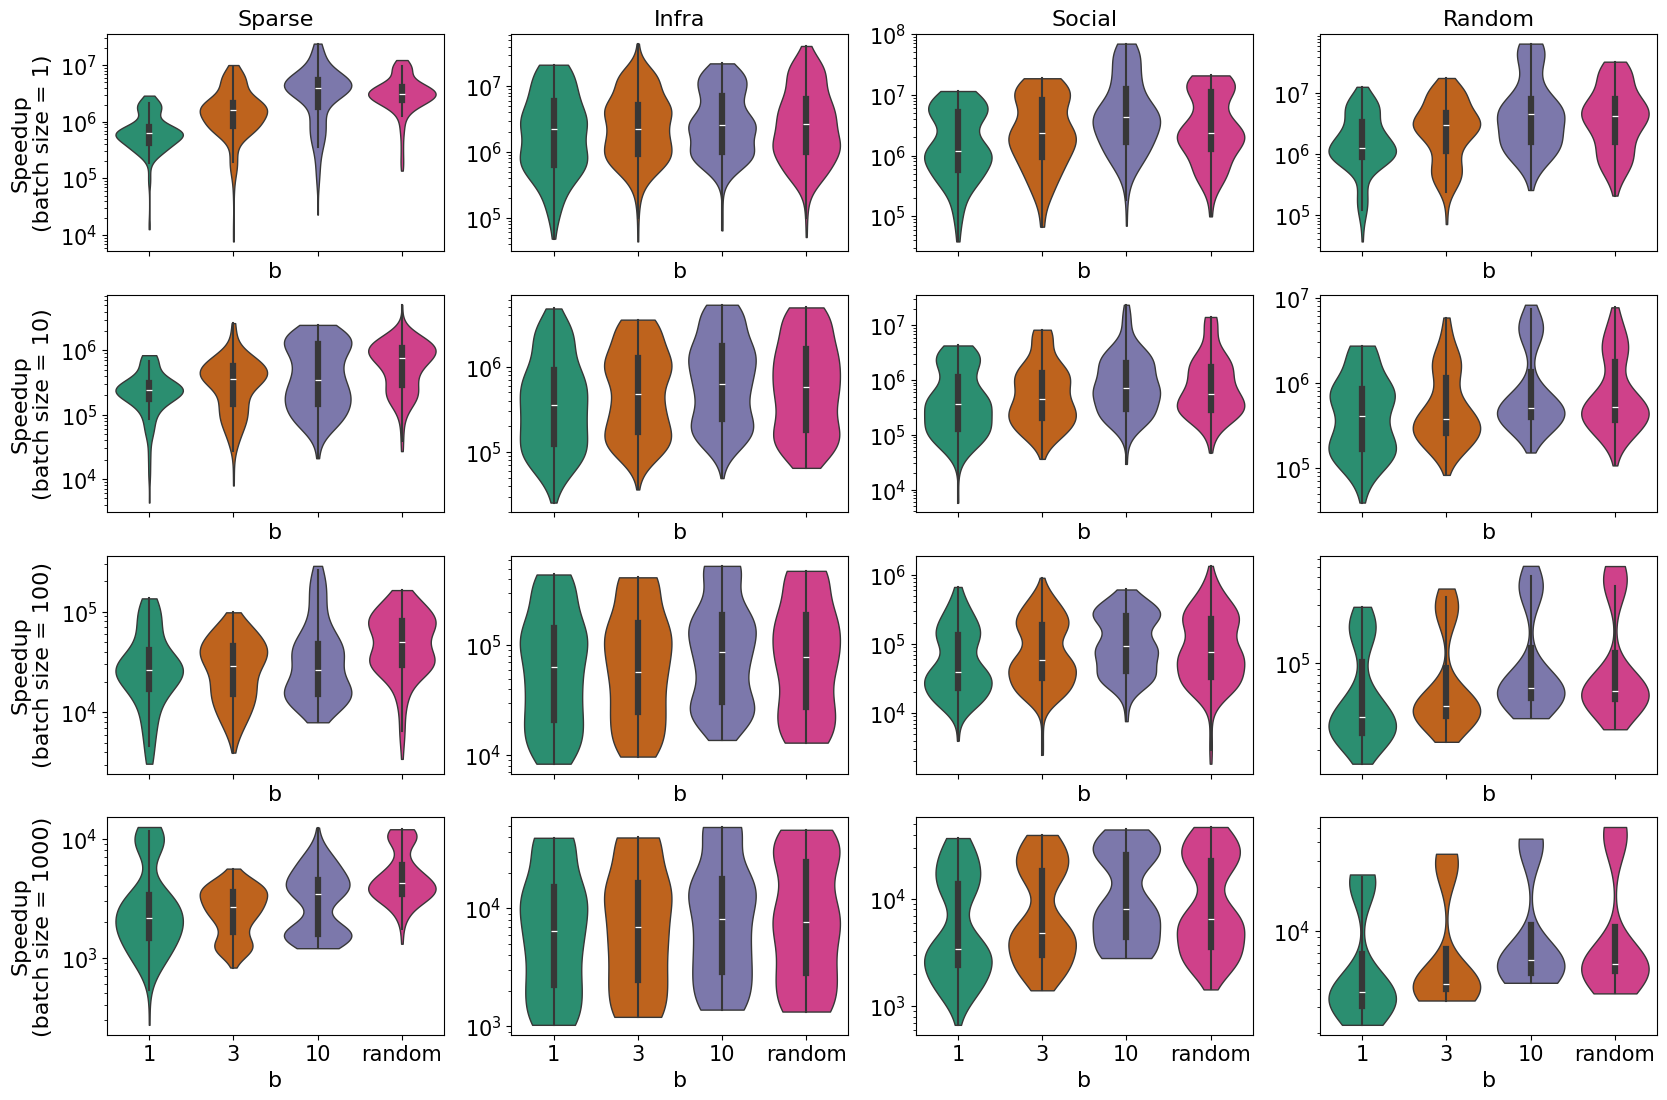

In [121]:
fig, axs = plt.subplots(4, 4, figsize=(20, 13), sharex='all')

cols = ['{}'.format(col) for col in ['Sparse', 'Infra', 'Social', 'Random']]
rows = ['{}'.format(col) for col in ['Speedup\n(batch size = 1)', 'Speedup\n(batch size = 10)', 'Speedup\n(batch size = 100)', 'Speedup\n(batch size = 1000)']]

for ax, col in zip(axs[0], cols):
    ax.set_title(col, fontsize=TITLE_SIZE)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=LABEL_SIZE, labelpad=5)

for i in range(4):
    for ax in axs[i,:]:
        ax.set_xlabel('b', fontsize=LABEL_SIZE)

#for iy, ix in np.ndindex(axs.shape):
#    axs[iy, ix].set_yscale('log')

#fig.suptitle("Edge Insertion", y=0.92, fontsize=15)
    
df_speedup.groupby('batch_size').apply(plotter, op = 'insert', column = 'speedup', log = True)
plt.savefig('./plots/speedup_insertion_misc.pdf', format="pdf", bbox_inches='tight')

#### Edge Removal

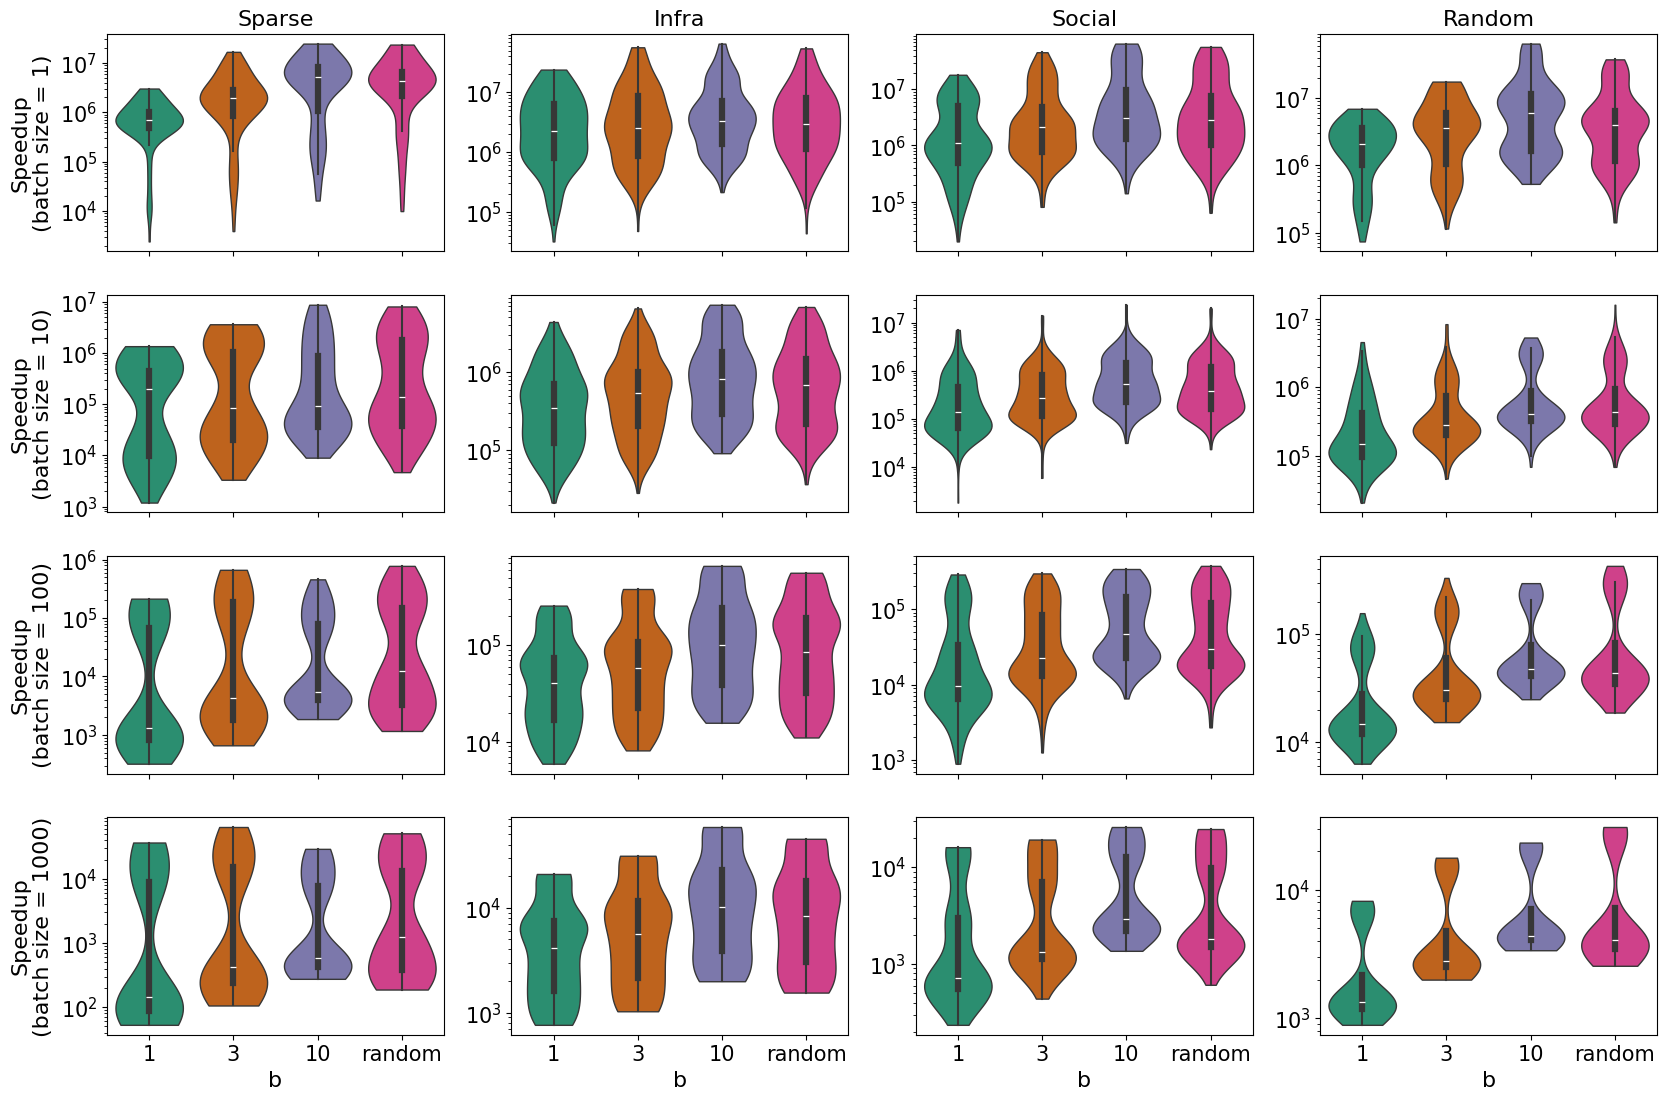

In [122]:
fig, axs = plt.subplots(4, 4, figsize=(20, 13), sharex='all')

for ax, col in zip(axs[0], cols):
    ax.set_title(col, fontsize=TITLE_SIZE)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=LABEL_SIZE, labelpad=5)

for i in range(4):
    for ax in axs[3,:]:
        ax.set_xlabel('b', fontsize=LABEL_SIZE)

#for iy, ix in np.ndindex(axs.shape):
#    axs[iy, ix].set_yscale('log')
    
#fig.suptitle("Edge Removal", y=0.92, fontsize=LABEL_SIZE)
    
df_speedup.groupby('batch_size').apply(plotter, op = 'remove', column = 'speedup', log = True)
plt.savefig('./plots/speedup_removal_misc.pdf', format="pdf", bbox_inches='tight')

### Average speedup

In [23]:
from scipy.stats.mstats import gmean

avg_speedup_single_combined = df_speedup.query('batch_size == "10e0"')['speedup'].sum()
avg_speedup_single_insertion = df_speedup.query('batch_size == "10e0" and operation == "insert"')['speedup'].sum()
avg_speedup_single_removal = df_speedup.query('batch_size == "10e0" and operation == "remove"')['speedup'].sum()
avg_speedup_single_insertion_sparse = df_speedup.query('batch_size == "10e0" and operation == "insert" and group == "real_sparse"')['speedup'].sum()
avg_speedup_single_insertion_infra = df_speedup.query('batch_size == "10e0" and operation == "insert" and group == "real_infrastructure"')['speedup'].sum()
avg_speedup_single_insertion_social = df_speedup.query('batch_size == "10e0" and operation == "insert" and group == "real_social"')['speedup'].sum()
avg_speedup_single_insertion_random = df_speedup.query('batch_size == "10e0" and operation == "insert" and group == "random"')['speedup'].sum()
mask = df_speedup.b.apply(lambda x: '1' in x)
avg_speedup_single_ordinary = df_speedup[mask].query('batch_size == "10e0"')['speedup'].sum()

print("Single update (combined): ",np.format_float_scientific(gmean(avg_speedup_single_combined)))
print("Single update (insertion): ",np.format_float_scientific(gmean(avg_speedup_single_insertion)))
print("Single update (removal): ",np.format_float_scientific(gmean(avg_speedup_single_removal)))
print("Single update (insertion, sparse): ",np.format_float_scientific(gmean(avg_speedup_single_insertion_sparse)))
print("Single update (insertion, infrastructure): ",np.format_float_scientific(gmean(avg_speedup_single_insertion_infra)))
print("Single update (insertion, social): ",np.format_float_scientific(gmean(avg_speedup_single_insertion_social)))
print("Single update (insertion, random): ",np.format_float_scientific(gmean(avg_speedup_single_insertion_random)))
print("Single update (ordinary): ",np.format_float_scientific(gmean(avg_speedup_single_ordinary)))

avg_speedup_batch_combined = df_speedup.query('batch_size == "10e3"')['speedup'].sum()
avg_speedup_batch_insertion = df_speedup.query('batch_size == "10e3" and operation == "insert"')['speedup'].sum()
avg_speedup_batch_removal = df_speedup.query('batch_size == "10e3" and operation == "remove"')['speedup'].sum()
avg_speedup_batch_ordinary = df_speedup[mask].query('batch_size == "10e3"')['speedup'].sum()
avg_speedup_batch_combined_sparse = df_speedup.query('batch_size == "10e3" and group == "real_sparse"')['speedup'].sum()
avg_speedup_batch_combined_infra = df_speedup.query('batch_size == "10e3" and group == "real_infrastructure"')['speedup'].sum()
avg_speedup_batch_combined_social = df_speedup.query('batch_size == "10e3" and group == "real_social"')['speedup'].sum()
avg_speedup_batch_combined_random = df_speedup.query('batch_size == "10e3" and group == "random"')['speedup'].sum()

print("Batch update (combined): ",np.format_float_scientific(gmean(avg_speedup_batch_combined)))
print("Batch update (insertion): ",np.format_float_scientific(gmean(avg_speedup_batch_insertion)))
print("Batch update (removal): ",np.format_float_scientific(gmean(avg_speedup_batch_removal)))
print("Batch update (ordinary): ",np.format_float_scientific(gmean(avg_speedup_batch_ordinary)))
print("Batch update (combined, sparse): ",np.format_float_scientific(gmean(avg_speedup_batch_combined_sparse)))
print("Batch update (combined, infrastructure): ",np.format_float_scientific(gmean(avg_speedup_batch_combined_infra)))
print("Batch update (combined, social): ",np.format_float_scientific(gmean(avg_speedup_batch_combined_social)))
print("Batch update (combined, random): ",np.format_float_scientific(gmean(avg_speedup_batch_combined_random)))

avg_speedup_combined_10 = df_speedup.query('batch_size == "10e1"')['speedup'].sum()
avg_speedup_combined_100 = df_speedup.query('batch_size == "10e2"')['speedup'].sum()
print("Batch update (combined,10): ",np.format_float_scientific(gmean(avg_speedup_combined_10)))
print("Batch update (combined,100): ",np.format_float_scientific(gmean(avg_speedup_combined_100)))

Single update (combined):  2.227020268017185e+06
Single update (insertion):  2.2000153533084574e+06
Single update (removal):  2.2543566646936797e+06
Single update (insertion, sparse):  1.5870832447999988e+06
Single update (insertion, infrastructure):  2.3361521792875817e+06
Single update (insertion, social):  2.447898583410462e+06
Single update (insertion, random):  2.646277925304112e+06
Single update (ordinary):  1.2705704788366347e+06
Batch update (combined):  4.313468997848058e+03
Batch update (insertion):  5.811667296850539e+03
Batch update (removal):  3.2014934518841574e+03
Batch update (ordinary):  2.876058712146888e+03
Batch update (combined, sparse):  2.07624547171081e+03
Batch update (combined, infrastructure):  6.50640316587374e+03
Batch update (combined, social):  4.644981314175667e+03
Batch update (combined, random):  5.294117940221345e+03
Batch update (combined,10):  3.8693136082609993e+05
Batch update (combined,100):  4.364665736732546e+04


## Parallel

In [104]:
# Exclude runs with wrong results, marked by "We are screwed" string in output file
def check_result(run):
    oFile = run.open_output_file()
    if 'We are screwed' in oFile.read():
        return False
    return True
    
def parse_par(run):
    # Get all used parameter
    var_dict = dict()
    for var in run.experiment.variation:
        var_dict[var.axis] = var.name

    output_dict = dict()
    # Read output
    oFile = run.open_output_file()
    par_runtime = 0.0
    
    for line in oFile:
        if line.startswith('Matching Time:'):
            par_runtime = float(line.split(':')[1].strip())
            
    inst = run.instance.shortname.split('-mtx')[0]
    group = list(run.instance.instsets)[0].split('_mtx')[0]
    
    return {
        'experiment': run.experiment.name,
        'instance': inst,
        'group': group,
        'b': var_dict['b_value'].split('3_b_val=')[1],
        'par_runtime': par_runtime
    }

In [25]:
results_par = []
for successful_run in cfg.collect_successful_results():
    if 'static-b-suitor-par' in successful_run.experiment.name and check_result(successful_run):
        results_par.append(parse_par(successful_run))

In [26]:
df_par = pd.DataFrame(results_par)
df_par = df_par.sort_values(by=['group'])

groupSeries = np.sort(pd.unique(df_par.group)).astype(str)
df_par['group'] = pd.Categorical(df_par['group'], categories=groupSeries, ordered=True)

df_par

,experiment,instance,group,b,par_runtime
37,static-b-suitor-par,rmat-g,random,10,0.029113
73,static-b-suitor-par,rmat-b,random,3,0.013447
68,static-b-suitor-par,hyp-24-1,random,3,1.239610
56,static-b-suitor-par,rmat-g,random,2,0.011093
55,static-b-suitor-par,rmat-er,random,2,0.010297
...,...,...,...,...,...
25,static-b-suitor-par,cage15,real_sparse,10,0.090595
5,static-b-suitor-par,cage14,real_sparse,1,0.014304
48,static-b-suitor-par,human_gene2,real_sparse,2,0.022659
43,static-b-suitor-par,cage14,real_sparse,2,0.017343


In [113]:
if not 'par_speedup' in df_seq.columns:
    init_list = [[]] * df_seq.shape[0]
    df_seq.insert(df_seq.shape[1], 'par_speedup',init_list)

for i, row in df_seq.iterrows():
    inst = row['instance']
    b = row['b']
    dQuery = df_par.query('instance == @inst and b == @b')
    if len(dQuery.index) > 0:
        speedup_values = [0.0] * 50
        par_runtime = dQuery['par_runtime'].item()
        for idx, val in enumerate(row['dyn_runtime']):
            speedup_values[idx] = par_runtime / val
        df_seq['par_speedup'][i] = speedup_values

In [114]:
df_par_speedup = df_seq.loc[(df_seq['b'] != 'random')].groupby(['group','b','batch_size']).agg({'par_speedup' : 'sum'})
df_par_speedup.reset_index(inplace=True)

for i, row in df_par_speedup.iterrows():
    local_b = [row['b']] * len(row['par_speedup'])
    df_par_speedup['b'][i] = local_b


### Parallel speedup plot

In [115]:
# Plotting function
def par_plotter(localDf, column, log = False):
    if (localDf['batch_size'] == '10e0').all():
        y = 0
    if (localDf['batch_size'] == '10e3').all():
        y = 1
    for i, val in enumerate(["real_sparse", "real_infrastructure", "real_social", "random"]):
        localQuery = localDf.query('group == @val')
        sns.violinplot(x=localQuery['b'].sum(), y=localQuery[column].sum(), bw_adjust=1.2, palette="Dark2", linewidth=1, cut=0, density_norm="count", ax=axs[y, i], order=[ '1', '2', '3', '10'], log_scale=log)

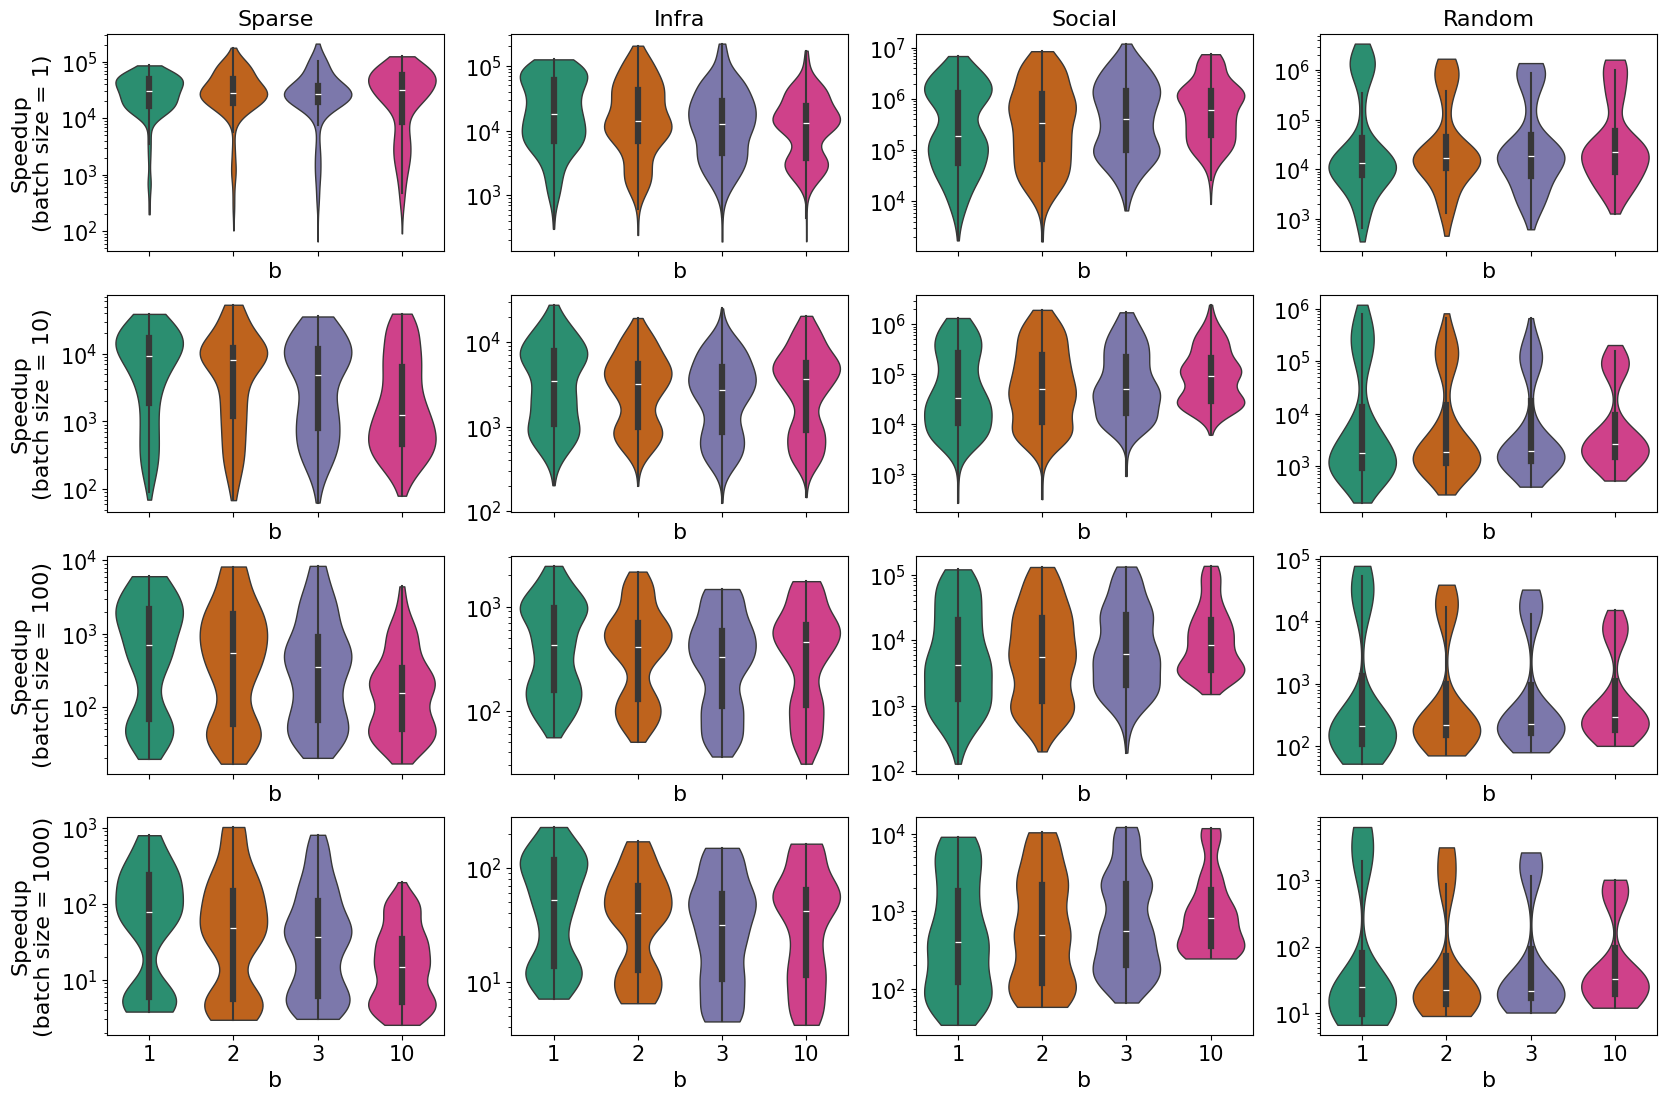

In [124]:
fig, axs = plt.subplots(4, 4, figsize=(20, 13), sharex='all')

for ax, col in zip(axs[0], cols):
    ax.set_title(col, fontsize=TITLE_SIZE)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=LABEL_SIZE, labelpad=5)

for i in range(4):
    for ax in axs[i,:]:
        ax.set_xlabel('b', fontsize=LABEL_SIZE)
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
    
df_par_speedup.groupby('batch_size').apply(plotter, column = 'par_speedup', log = True, order=[ '1', '2', '3', '10'])
plt.savefig('./plots/speedup_parallel_misc.pdf', format="pdf", bbox_inches='tight')

### Average parallel speedup

In [26]:
avg_speedup_single_combined = df_par_speedup.query('batch_size == "10e0"')['par_speedup'].sum()
avg_speedup_single_sparse = df_par_speedup.query('batch_size == "10e0" and group == "real_sparse"')['par_speedup'].sum()
avg_speedup_single_infra = df_par_speedup.query('batch_size == "10e0" and group == "real_infrastructure"')['par_speedup'].sum()
avg_speedup_single_social = df_par_speedup.query('batch_size == "10e0" and group == "real_social"')['par_speedup'].sum()
avg_speedup_single_random = df_par_speedup.query('batch_size == "10e0" and group == "random"')['par_speedup'].sum()
mask_b1 = df_par_speedup.b.apply(lambda x: '1' in x)
mask_b2 = df_par_speedup.b.apply(lambda x: '2' in x)
mask_b3 = df_par_speedup.b.apply(lambda x: '3' in x)
mask_b10 = df_par_speedup.b.apply(lambda x: '10' in x)
avg_speedup_single_ordinary = df_par_speedup[mask].query('batch_size == "10e0"')['par_speedup'].sum()

print("Single update (combined): ",np.format_float_scientific(gmean(avg_speedup_single_combined)))
print("Single update (combined, min): ",np.format_float_scientific(np.min(avg_speedup_single_combined)))
print("Single update (sparse): ",np.format_float_scientific(gmean(avg_speedup_single_sparse)))
print("Single update (infrastructure): ",np.format_float_scientific(gmean(avg_speedup_single_infra)))
print("Single update (social): ",np.format_float_scientific(gmean(avg_speedup_single_social)))
print("Single update (random): ",np.format_float_scientific(gmean(avg_speedup_single_random)))
print("Single update (ordinary): ",np.format_float_scientific(gmean(avg_speedup_single_ordinary)))

avg_speedup_batch_combined = df_par_speedup.query('batch_size == "10e3"')['par_speedup'].sum()
avg_speedup_batch_b1 = df_par_speedup[mask_b1].query('batch_size == "10e3"')['par_speedup'].sum()
avg_speedup_batch_b2 = df_par_speedup[mask_b2].query('batch_size == "10e3"')['par_speedup'].sum()
avg_speedup_batch_b3 = df_par_speedup[mask_b3].query('batch_size == "10e3"')['par_speedup'].sum()
avg_speedup_batch_b10 = df_par_speedup[mask_b10].query('batch_size == "10e3"')['par_speedup'].sum()

print("Batch update (combined): ",np.format_float_scientific(gmean(avg_speedup_batch_combined)))
print("Batch update (combined, min): ",np.format_float_scientific(np.min(avg_speedup_batch_combined)))
print("Batch update (b=1): ",np.format_float_scientific(gmean(avg_speedup_batch_b1)))
print("Batch update (b=2): ",np.format_float_scientific(gmean(avg_speedup_batch_b2)))
print("Batch update (b=3): ",np.format_float_scientific(gmean(avg_speedup_batch_b3)))
print("Batch update (b=10): ",np.format_float_scientific(gmean(avg_speedup_batch_b10)))

avg_speedup_combined_10 = df_par_speedup.query('batch_size == "10e1"')['par_speedup'].sum()
avg_speedup_combined_100 = df_par_speedup.query('batch_size == "10e2"')['par_speedup'].sum()
print("Batch update (combined,10): ",np.format_float_scientific(gmean(avg_speedup_combined_10)))
print("Batch update (combined,100): ",np.format_float_scientific(gmean(avg_speedup_combined_100)))

Single update (combined):  3.69113759432742e+04
Single update (combined, min):  6.582553827105802e+01
Single update (sparse):  2.3023656899381545e+04
Single update (infrastructure):  1.3713062894743716e+04
Single update (social):  3.6652166650961357e+05
Single update (random):  2.9613645917508875e+04
Single update (ordinary):  1.019146320860884e+05
Batch update (combined):  6.92598206046257e+01
Batch update (combined, min):  2.551114353475776e+00
Batch update (b=1):  8.139611848428589e+01
Batch update (b=2):  7.210312204071532e+01
Batch update (b=3):  6.602460029534387e+01
Batch update (b=10):  5.938296843510858e+01
Batch update (combined,10):  6.238870585582431e+03
Batch update (combined,100):  7.000915610997233e+02
